# 1. Makine Öğrenmesi ile Hastalık Tahmini

## 1.1 Gerekli kütüphanelerin ve verinin yüklenmesi

Hastalık tahmininde Naive Bayes modeli tercih edilmiştir. Bu modelin predict metodu için scikit-learn kütüphanesinin uygun versiyonu yüklenmiştir. 

In [67]:
!pip install scikit-learn==0.24.2

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

#modeller
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [69]:
veri_komb = pd.read_csv('veri_komb.csv', encoding='iso-8859-9', sep=",")
veri_komb.set_index('hastalik').head()

,baş ağrısı,bulanık görme,burun kanaması,düzensiz kalp ritmi,göğüs ağrısı,göğüste baskı,idrarda kan,nefes darlığı,ciltte kırmızlık,kaşıntı,...,öğün atlamak,şiş boğaz,hafıza kaybı,ruh hali değişimleri,kanlı balgam,ağız içinde yumru,ağızda uyuşma,gevşek diş,iyileşmeyen ağız yarası,koyu cilt
hastalik,,,,,,,,,,,,,,,,,,,,,
addison_hastalığı,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
addison_hastalığı,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
addison_hastalığı,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
addison_hastalığı,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
addison_hastalığı,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 1.2 Verinin Düzenlenmesi

1. Veri semptomlar ve tahmin edilmesi gereken hastalık olarak ayrıldı. 

2. Hastalık verisi string formatında olduğundan makine öğrenmesi algoritmasına girdi olarak verilebilmesi için float tipine dönüştürülmelidir. Bu dönüşüm **label encoder** kullanılarak yapıldı. Label encoder, n toplam hastalık sayısı olmak üzere 1'den n'e her bir hastalığı bir sayı ile eşleştirir. 

3. Veri eğitim (%70) ve test (%30) olmak üzere ayrıldı. 

In [70]:
semptomlar = veri_komb.iloc[:, :-1]
hastalik_string = veri_komb.hastalik

In [71]:
le = LabelEncoder()
le.fit(hastalik_string.tolist())
hastalik = le.transform(hastalik_string)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(semptomlar, hastalik, test_size=0.3, random_state=42)

## 1.3 Modellerin Kurulması

Tezimizde [en yaygın kullanılan 5 sınıflandırma modeli,](https://monkeylearn.com/blog/classification-algorithms/) random forest ve yapay sinir ağı modelini kuracağız. 

Son olarak modeller arasından chatbot uygulamamızda kullanmak üzere modelimizi seçip kaydedeceğiz. 

Kuracağımız modeller şunlardır:

1. Logistic Regression
2. Naive Bayes
3. K-Nearest Neighbors
4. Decision Tree
5. Random Forest
6. Support Vector Machines
7. Multi-layer Perceptron Classifier

1.4 bölümünde modeller arası başarı karşılaştırılacağından test, train accuracy değerleri her bir model için listede saklanacaktır.


In [73]:
train_accuracy = []
test_accuracy = []

### 1.3.1 Logistic Regression

Logistic regression iki sınıf içeren verileri sınıflandırmada kullanılır. Bizim verimiz ise 76 sınıf bulundurmaktadır. Bu yüzden bu sınıflandırma türünün ikiden fazla sınıf için genişletilmiş hali olan **multinomial logistic regression (softmax regression)** kullanılacaktır. 


Softmax regression her bir veri için çıktı olarak toplam değeri 1 olup 76 satırdan oluşan bir olasılık vektörü döndürür. En yüksek değer sınıflandırılan sınıf olur. 

Pipeline içerisinde sırasıyla StandardScaler, PCA ve logistic regression modelimiz bulunmaktadır.

StandardScaler ile aykırı (outlier) değerleri kaldırıp verilerin ortalamasını 0 standart sapmasını 1 yaparak ölçekleriz. 

Bunu yapmamız nedeni değişkenlerin modele eşit katkı yapmasını sağlamak ve yanlılık (bias) oluşumunun önüne geçmektir.

In [74]:
std_slc = StandardScaler()


PCA (Principal Component Analysis) orijinal verilerin varyansının çoğuna sahip yeni özellikler oluşturur böylece özelliklerimizin boyutunu azaltır. PCA özellikle verimiz fazla boyutlu olduğunda yaratacağı gürültü ve zorluğu aşmakta yani **curse of dimensionality** problemini aşmamızda bize yardımcı olur. 

In [75]:
pca = decomposition.PCA()

Modelimizi bir **pipeline** içinde kuruyoruz. Pipeline içerisinde sırasıyla hangi fonksiyonları çalıştırmamız gerektiğini belirtiyoruz. 



In [76]:
def pipeline(model):
  pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('model', model)])
  return pipe

In [77]:
logistic_reg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100)

pipe = pipeline(logistic_reg)

In [78]:
pipe.fit(X_train, y_train)
y_predLR = pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [79]:
lr_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
lr_test_accuracy = accuracy_score(y_test, y_predLR)

train_accuracy.append(lr_train_accuracy)
test_accuracy.append(lr_test_accuracy)

print("Train Accuracy: ", lr_train_accuracy)
print("Test Accuracy: ", lr_test_accuracy)

Train Accuracy:  0.9419900908340215
Test Accuracy:  0.9224470134874759


### 1.3.2 Naive Bayes

In [80]:
naive_bayes = GaussianNB()
pipe = pipeline(naive_bayes)

pipe.fit(X_train, y_train)
y_predNB = pipe.predict(X_test)

In [81]:
nb_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
nb_test_accuracy = accuracy_score(y_test, y_predNB)

train_accuracy.append(nb_train_accuracy)
test_accuracy.append(nb_test_accuracy)

print("Train Accuracy: ", nb_train_accuracy)
print("Test Accuracy: ", nb_test_accuracy)

Train Accuracy:  0.9364161849710982
Test Accuracy:  0.9253371868978806


### 1.3.3 K-Nearest Neighbors

In [82]:
knn = KNeighborsClassifier()
pipe = pipeline(knn)

pipe.fit(X_train, y_train)
y_predKNN = pipe.predict(X_test)

In [83]:
knn_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
knn_test_accuracy = accuracy_score(y_test, y_predKNN)

train_accuracy.append(knn_train_accuracy)
test_accuracy.append(knn_test_accuracy)

print("Train Accuracy: ", knn_train_accuracy)
print("Test Accuracy: ", knn_test_accuracy)

Train Accuracy:  0.9335260115606936
Test Accuracy:  0.8998073217726397


### 1.3.4 Decision Tree

In [84]:
dt = DecisionTreeClassifier(splitter='best', criterion='entropy', min_samples_leaf=2)
pipe = pipeline(dt)

pipe.fit(X_train, y_train)
y_predDT = pipe.predict(X_test)

In [85]:
dt_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
dt_test_accuracy = accuracy_score(y_test, y_predDT)

train_accuracy.append(dt_train_accuracy)
test_accuracy.append(dt_test_accuracy)

print("Train Accuracy: ", dt_train_accuracy)
print("Test Accuracy: ", dt_test_accuracy)

Train Accuracy:  0.9413707679603633
Test Accuracy:  0.859344894026975


### 1.3.5 Random Forest

In [86]:
rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=2)
pipe = pipeline(rf)

pipe.fit(X_train, y_train)
y_predRF = pipe.predict(X_test)

In [87]:
rf_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
rf_test_accuracy = accuracy_score(y_test, y_predRF)

train_accuracy.append(rf_train_accuracy)
test_accuracy.append(rf_test_accuracy)

print("Train Accuracy: ", rf_train_accuracy)
print("Test Accuracy: ", rf_test_accuracy)

Train Accuracy:  0.9479768786127167
Test Accuracy:  0.9026974951830443


### 1.3.6 Support Vector Machines

In [88]:
svc = SVC()
pipe = pipeline(svc)

pipe.fit(X_train, y_train)
y_predSVC = pipe.predict(X_test)

In [89]:
svc_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
svc_test_accuracy = accuracy_score(y_test, y_predSVC)

train_accuracy.append(svc_train_accuracy)
test_accuracy.append(svc_test_accuracy)

print("Train Accuracy: ", svc_train_accuracy)
print("Test Accuracy: ", svc_test_accuracy)

Train Accuracy:  0.9229975227085053
Test Accuracy:  0.9089595375722543


### 1.3.7 MLP Classifier

In [90]:
mlp = MLPClassifier()
pipe = pipeline(mlp)

pipe.fit(X_train, y_train)
y_predMLP = pipe.predict(X_test)

In [91]:
mlp_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
mlp_test_accuracy = accuracy_score(y_test, y_predMLP)

train_accuracy.append(mlp_train_accuracy)
test_accuracy.append(mlp_test_accuracy)

print("Train Accuracy: ", mlp_train_accuracy)
print("Test Accuracy: ", mlp_test_accuracy)

Train Accuracy:  0.9479768786127167
Test Accuracy:  0.9099229287090559


## 1.4 Model Başarılarının Yorumlanması

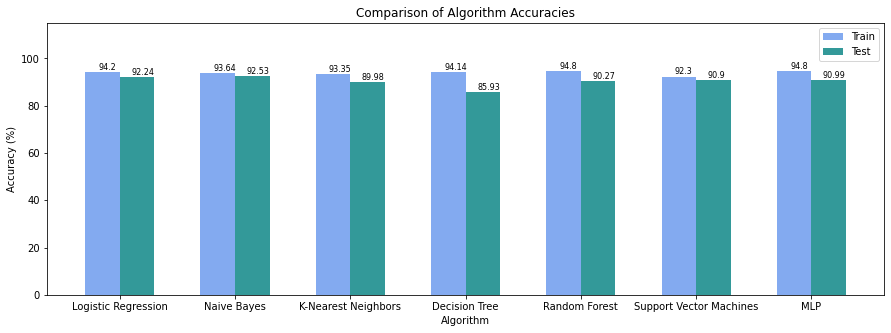

In [92]:
n_groups = 7
algorithms = ('Logistic Regression', 'Naive Bayes', 'K-Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Support Vector Machines', 'MLP')
train_accuracy_perc = [i * 100 for i in train_accuracy]
test_accuracy_perc = [i * 100 for i in test_accuracy]

fig, ax = plt.subplots(figsize=(15, 5))
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8
rects1 = plt.bar(index, train_accuracy_perc, bar_width, alpha = opacity, color='Cornflowerblue', label='Train')
rects2 = plt.bar(index + bar_width, test_accuracy_perc, bar_width, alpha = opacity, color='Teal', label='Test')
plt.xlabel('Algorithm') # x axis label
plt.ylabel('Accuracy (%)') # y axis label
plt.ylim(0, 115)
plt.title('Comparison of Algorithm Accuracies') # plot title
plt.xticks(index + bar_width * 0.5, algorithms) # x axis data labels
plt.legend(loc = 'upper right') # show legend
for index, data in enumerate(train_accuracy_perc):
    plt.text(x = index - 0.035, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))
for index, data in enumerate(test_accuracy_perc):
    plt.text(x = index + 0.25, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))
plt.show()

## 1.5 Seçilen Modelin Kaydedilmesi

In [93]:
naive_bayes = GaussianNB()
pipe = pipeline(naive_bayes)

pipe.fit(X_train.values, y_train)

Pipeline(steps=[('std_slc', StandardScaler()), ('pca', PCA()),
                ('model', GaussianNB())])

In [94]:
filename = 'model.sav'
pickle.dump(pipe, open(filename, 'wb'))

## 1.6 Kullanıcının Girdisi ile Tahmin 

In [97]:
kayıtlı_semptomlar = veri_komb.columns.values[:-1]
       
hastalıklar = veri_komb.hastalik.unique()

semptom_numarası = {}
for index, value in enumerate(kayıtlı_semptomlar):
    semptom_numarası[value] = index

data_dict = {
    "semptom_numarası":semptom_numarası,
    "tahmin_sınıfları":hastalıklar
}

filename = 'model.sav'
 
# Eğitilmiş modelin yüklenmesi
gs_NB = pickle.load(open(filename, 'rb'))

# Girdi: Virgüller ile ayrılmış semptomlar
# Çıktı: Tahmin edilen hastalığın ismi
def hastalık_tahmin_et(kayıtlı_semptomlar):

    kayıtlı_semptomlar = kayıtlı_semptomlar.split(",")

    # Modele uygun girdi verisinin hazırlanması 
    input_data = [0] * len(data_dict["semptom_numarası"])
    for semptom in kayıtlı_semptomlar:
        index = data_dict["semptom_numarası"][semptom]
        input_data[index] = 1
        
    input_data = np.array(input_data).reshape(1,-1)
    
    tahmin = data_dict["tahmin_sınıfları"][gs_NB.predict(input_data)[0]]

    return tahmin

In [98]:
print("Tahmin edilen hastalık: ", hastalık_tahmin_et("ateş,öksürük,baş ağrısı,boğaz ağrısı"))

Tahmin edilen hastalık:  farenjit


In [99]:
print("Tahmin edilen hastalık: ", hastalık_tahmin_et("ciltte kaşıntı,ciltte döküntü,ciltte yanma"))

Tahmin edilen hastalık:  egzama


In [100]:
print("Tahmin edilen hastalık: ", hastalık_tahmin_et("saç dökülmesi"))

Tahmin edilen hastalık:  saçkıran


In [101]:
print("Tahmin edilen hastalık: ", hastalık_tahmin_et("sıvı dışkı,bulantı,karın ağrısı"))

Tahmin edilen hastalık:  ishal
